Always run the following 3 cells first.

In [1]:
from datasets.sequence_generator import generate_examples

import argparse

import torch.nn as nn
import torch

import harvard_transformer as tr
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import intrinsic_dimension as idims


In [2]:
##### DATA PARAMETERS #####
dataset_file = "ten_tokens_explicit_singular_data.txt"
vocabulary_file = 'datasets/ten_tokens_explicit.txt'
operation_type = 'singular'
transition_type = 'explicit'

##### MODEL PARAMETERS #####
num_layers = 2
num_heads = 4
hidden_size = 16 # The hidden size MUST be divisible by the number of heads and even
model_save = 'transformer_hid_'+str(hidden_size)+'_heads_'+str(num_heads)+'_lyrs_'+str(num_layers)+'.mdl'

##### TRAINING PARAMETERS #####
batch_size = 24
num_batches = 100
num_epochs = 100
print_frequency = 10

In [3]:
def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def data_generator(vocabulary, batch_size, num_batches, Ks=[2,4,5,7]):
    "Generate random data for a src-tgt copy task."
    for btch in range(num_batches):
        selected_ks = np.random.choice(Ks, batch_size)

        pad = len(vocabulary)
        srcs = []
        tgts = []
        for lk in selected_ks:
            output = generate_examples(transition_type = transition_type, \
                                        operation_type = operation_type, \
                                        vocabulary = vocabulary, \
                                        k = lk, \
                                        num_examples=1).strip()

            training_line, target = output.split(';')
            training_sequence = training_line.split(' ')

            src = []
            for char in training_sequence:
                src.append(vocabulary.index(char))

            for padding_char in range(20 - len(training_sequence)):
                src.append(pad)

            tgt = [pad, vocabulary.index(target)]
            # for padding_char in range(20 - len(tgt)):
            #     tgt.append(pad)

            srcs.append(src)
            tgts.append(tgt)

        srcs = torch.from_numpy(np.array(srcs))
        tgts = torch.from_numpy(np.array(tgts))

        # data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        # data[:, 0] = 1
        srcs = Variable(srcs, requires_grad=False)
        tgts = Variable(tgts, requires_grad=False)
        # import pdb; pdb.set_trace()

        yield tr.Batch(srcs, tgts, pad)

def data_sample(vocabulary, Ks=[2,4,5,7], verbose=False):
    "Generate random data for a src-tgt copy task."
    pad = len(vocabulary)
    output = generate_examples(transition_type = transition_type, \
                               operation_type = operation_type, \
                               vocabulary = vocabulary, \
                               k = np.random.choice(Ks), \
                               num_examples=1).strip()

    training_line, target = output.split(';')
    training_sequence = training_line.split(' ')

    src = []
    for char in training_sequence:
        src.append(vocabulary.index(char))

    for padding_char in range(20 - len(training_sequence)):
        src.append(pad)

    tgt = [pad, vocabulary.index(target)]
            # for padding_char in range(20 - len(tgt)):
            #     tgt.append(pad)

    src = Variable(torch.from_numpy(np.array(src)), requires_grad=False)
    tgt = Variable(torch.from_numpy(np.array(tgt)), requires_grad=False)
        # import pdb; pdb.set_trace()
    if verbose:
        if transition_type == 'explicit':
            split_idx = training_sequence.index('|')
            remember = training_sequence[:split_idx]
            forget = training_sequence[split_idx+1:]
        return src.reshape(1,-1), tgt, len(remember), remember, forget
    return src, tgt

def generate_data_from_source(source):
    remember, forget = source.split('|')
    remember = remember.lstrip().strip().split(' ')
    forget = forget.lstrip().strip().split(' ')
    
    target = list(set(remember).difference(set(forget)))[0]
    tgt = [vocabulary.index(target)]
    
    k = len(remember)
    
    line = source.lstrip().strip().split(' ')
    
    src = []
    for token in line:
        src.append(vocabulary.index(token))
    
    src = src + [len(vocabulary)]*(20 - len(src))
    tgt = [len(vocabulary)]+tgt
    
    src = torch.Tensor(src).reshape(1,-1).long()
    tgt = torch.Tensor(tgt).long()
    
    return src,tgt, k, remember, forget

vocabulary = []
with open(vocabulary_file) as file:
    for line in file:
        vocabulary.append(line.strip())

The following cell only loads the model. If the parameters specified prebiously describe the model you wish to load then run this following cell to load the model into memory.

In [4]:
##### LOAD MODEL #####
model = tr.make_transformer(src_vocab=len(vocabulary)+1, \
                        tgt_vocab=len(vocabulary)+1, \
                        N=num_layers, \
                        d_model=hidden_size, \
                        d_ff=4*hidden_size, \
                        h=num_heads, \
                        dropout=0.0)
model.load_state_dict(torch.load(model_save))

The following cell trains a new model using the parameters set above. The model will be save ever `print_frequency` epochs under the name set in `model_save`

In [15]:
##### TRAIN MODEL #####
model = tr.make_transformer(src_vocab=len(vocabulary)+1, \
                        tgt_vocab=len(vocabulary)+1, \
                        N=num_layers, \
                        d_model=hidden_size, \
                        d_ff=4*hidden_size, \
                        h=num_heads, \
                        dropout=0.0)

criterion = nn.CrossEntropyLoss()

model_opt = tr.NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
print('Training Transformer')
for epoch in range(num_epochs):
    model.train()
    tr.run_epoch(data_generator(vocabulary, batch_size, num_batches), \
                model, \
              tr.SimpleLossCompute(model.generator, criterion, model_opt))
    
    if (epoch + 1) % print_frequency == 0:
        print('Epoch::'+str(epoch+1))
        model.eval()
        print(tr.run_epoch(data_generator(vocabulary, batch_size, 1), \
                    model, \
                  tr.SimpleLossCompute(model.generator, criterion, None)))
        torch.save(model.state_dict(), model_save)

Training Transformer
Epoch::10
0.013704151846468449
Epoch::20
0.0012474065879359841
Epoch::30
0.0014842943055555224
Epoch::40
0.00015806060400791466


KeyboardInterrupt: 

The following cell tests the model. Be sure to have either a model trained or loaded using one of the previous cells. 

In [16]:
##### TEST MODEL #####
model.eval()
for k in range(2,11):
    correct = 0
    for ex in range(2000):
        src, tgt = data_sample(vocabulary, Ks=[k])
        src = src.reshape(1,-1)
        true = tgt[1].item()
        
        src_mask = (src != len(vocabulary)).unsqueeze(-2)
        out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))
        
        pred = out[0][1].item()

        # print(pred, true)
        if pred == true:
            # print('CORR')
            correct += 1
    # import pdb; pdb.set_trace()
    print('Dataset L'+str(k)+' Accuracy: '+str(round(correct/2000*100, 2)) + '%')


Dataset L2 Accuracy: 100.0%
Dataset L3 Accuracy: 99.6%
Dataset L4 Accuracy: 99.95%
Dataset L5 Accuracy: 99.9%
Dataset L6 Accuracy: 99.95%
Dataset L7 Accuracy: 99.7%
Dataset L8 Accuracy: 98.8%
Dataset L9 Accuracy: 99.8%
Dataset L10 Accuracy: 100.0%


Encoder


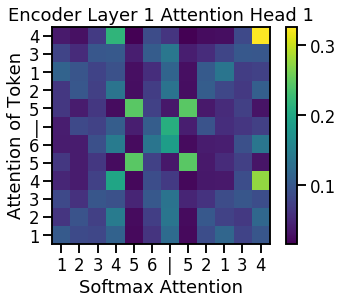

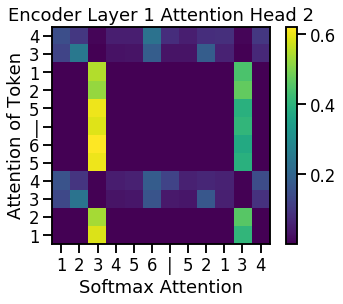

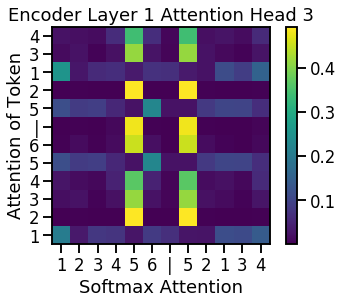

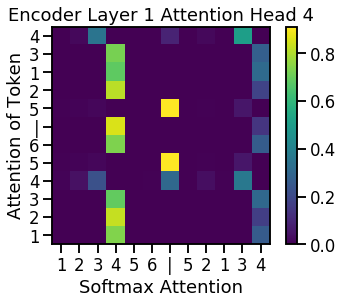

Encoder


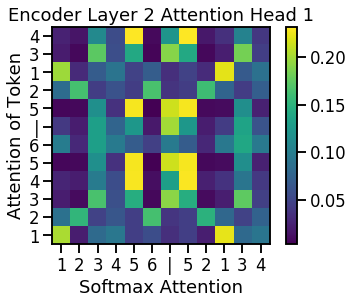

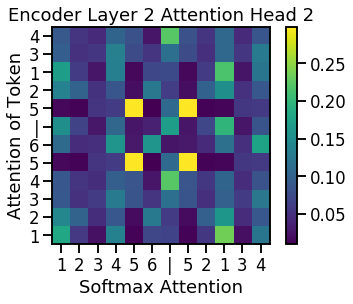

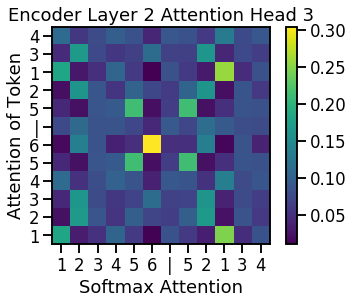

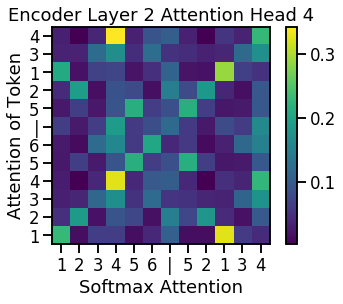

Decoder


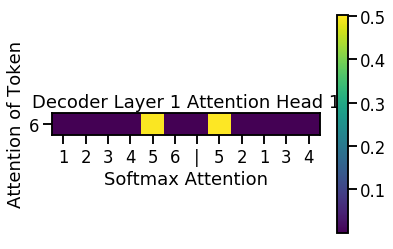

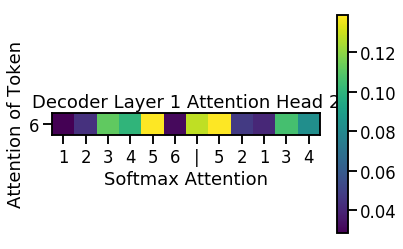

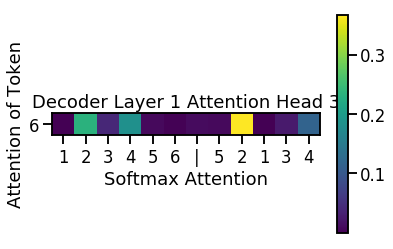

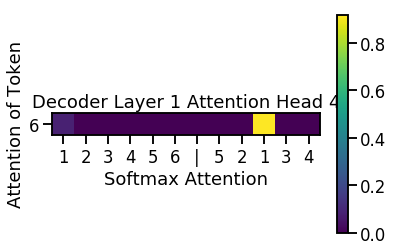

Decoder


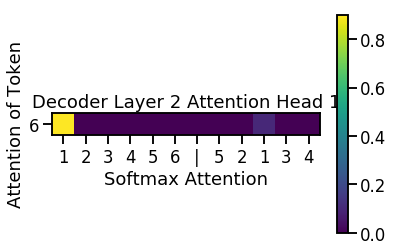

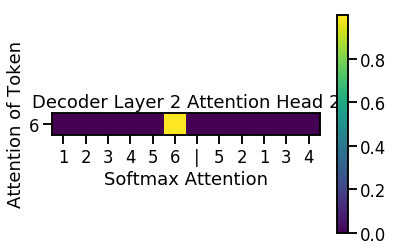

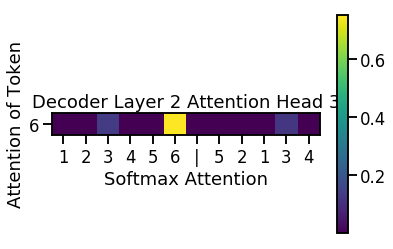

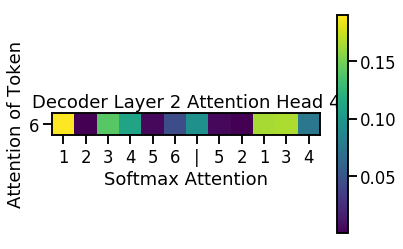

In [13]:
source_text = '1 2 3 4 5 6 | 5 2 1 3 4'
src, tgt, k, remember_text, forget_text = generate_data_from_source(source_text)

model.eval()

if transition_type == 'explicit' or transition_type == 'repeated':
    src_length = 2*k
else:
    src_length = 2*k - 1
        
true = tgt[1].item()
        
src_mask = (src != len(vocabulary)).unsqueeze(-2)
out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

encoder_output = model.encode(src, src_mask)

pred = out[0][1].item()
    
encoder_layers = model.encoder.layers
for lyr, encoder in enumerate(encoder_layers):
    print('Encoder')
    for head in range(num_heads):
        plt.title('Encoder Layer '+str(lyr+1)+' Attention Head '+str(head+1))
        plt.imshow(encoder.self_attn.attn[0,head,:src_length, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(src_length), list(source_text.split(' ')))
        plt.ylabel('Attention of Token')
        plt.xlabel('Softmax Attention')
        plt.colorbar()
        plt.show()

decoder_layers = model.decoder.layers
for lyr, decoder in enumerate(decoder_layers):
    print('Decoder')
#     print(decoder.src_attn.attn.shape)
#     print(decoder.src_attn.attn[:,0,0, :src_length].detach().numpy())
    for head in range(num_heads):
        plt.title('Decoder Layer '+str(lyr+1)+' Attention Head '+str(head+1))
        plt.imshow(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(1), [tgt.numpy()[1]])
        plt.ylabel('Attention of Token')
        plt.xlabel('Softmax Attention')
        plt.colorbar()
        plt.show()
    
# Dataset L2 Accuracy: 92.3%
# Dataset L3 Accuracy: 70.45%
# Dataset L4 Accuracy: 65.8%
# Dataset L5 Accuracy: 60.9%
# Dataset L6 Accuracy: 58.0%
# Dataset L7 Accuracy: 53.25%
# Dataset L8 Accuracy: 48.5%
# Dataset L9 Accuracy: 43.8%
# Dataset L10 Accuracy: 38.35%

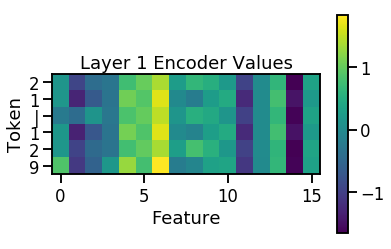

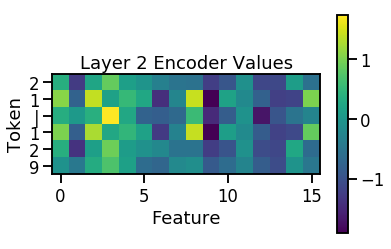

In [9]:
source_text = '9 2 1 | 1 2'
src, tgt, k, remember_text, forget_text = generate_data_from_source(source_text)

model.eval()

if transition_type == 'explicit' or transition_type == 'repeated':
    src_length = 2*k
else:
    src_length = 2*k - 1
        
true = tgt[1].item()
        
src_mask = (src != len(vocabulary)).unsqueeze(-2)
out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

encoder_layers = model.encoder.layers
for lyr, encoder in enumerate(encoder_layers):
    plt.title('Layer '+str(lyr+1)+' Encoder Values')
    plt.imshow(encoder.self_attn.projected_vectors[0,:src_length,:].detach().numpy(), origin='lower')
    plt.yticks(range(src_length), list(source_text.split(' ')))
    plt.ylabel('Token')
    plt.xlabel('Feature')
    plt.colorbar()
    plt.show()
    


The shape of attention is always `[1, #heads, #tokens, #tokens]`

The shape of projected vectors is `[1, #heads, #tokens, #d_model/#heads]`

Encoder


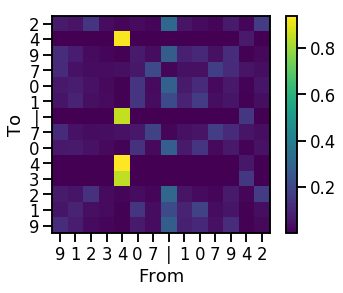

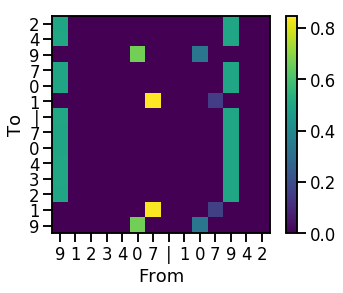

Encoder


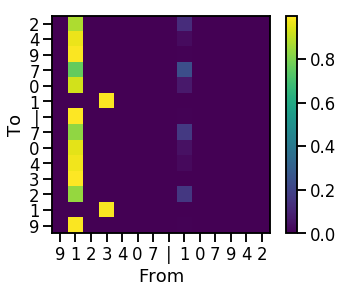

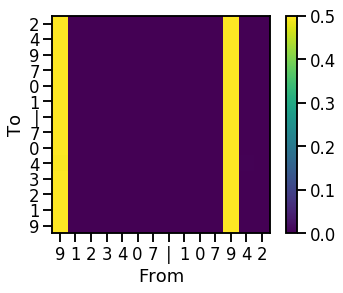

Decoder


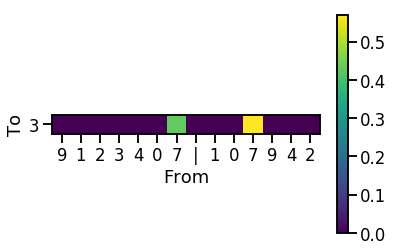

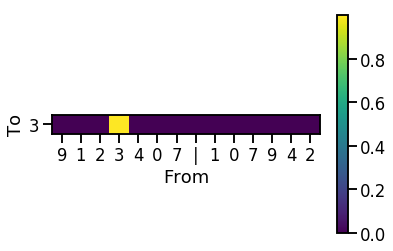

Decoder


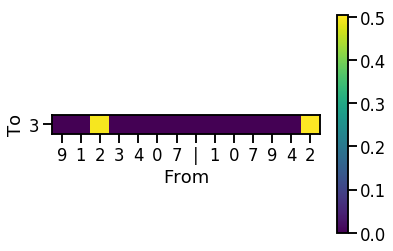

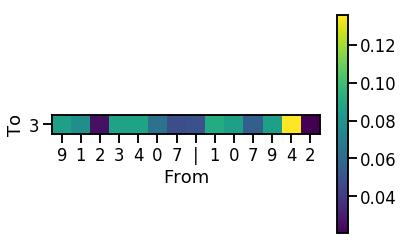

tensor([[ -7.2203,  -7.1090,  -8.5835,  -0.0599,  -6.3866,  -7.2248, -12.6990,
          -9.8170,  -2.9321,  -7.3793, -28.3823, -28.3225]],
       grad_fn=<LogSoftmaxBackward>)


In [5]:
source_text = '9 1 2 3 4 0 7 | 1 0 7 9 4 2'
src, tgt, k, remember_text, forget_text = generate_data_from_source(source_text)

model.eval()

if transition_type == 'explicit' or transition_type == 'repeated':
    src_length = 2*k
else:
    src_length = 2*k - 1
        
true = tgt[1].item()
        
src_mask = (src != len(vocabulary)).unsqueeze(-2)
out, out_prob = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary), verbose=True)

encoder_output = model.encode(src, src_mask)

pred = out[0][1].item()
    
encoder_layers = model.encoder.layers
for lyr, encoder in enumerate(encoder_layers):
    print('Encoder')
    for head in range(num_heads):
        plt.imshow(encoder.self_attn.attn[0,head,:src_length, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(src_length), list(source_text.split(' ')))
        plt.ylabel('To')
        plt.xlabel('From')
        plt.colorbar()
        plt.show()

decoder_layers = model.decoder.layers
for lyr, decoder in enumerate(decoder_layers):
    print('Decoder')
#     print(decoder.src_attn.attn.shape)
#     print(decoder.src_attn.attn[:,0,0, :src_length].detach().numpy())
    for head in range(num_heads):
        plt.imshow(decoder.src_attn.attn[:,head,0, :src_length].detach().numpy(), origin='lower')
        plt.xticks(range(src_length), list(source_text.split(' ')))
        plt.yticks(range(1), [tgt.numpy()[1]])
        plt.ylabel('To')
        plt.xlabel('From')
        plt.colorbar()
        plt.show()

print(out_prob)

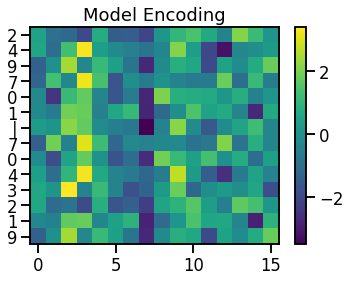

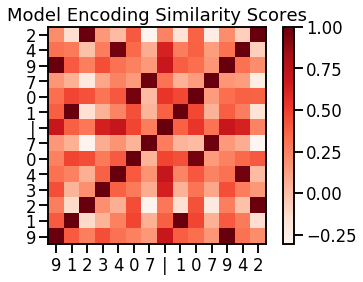

In [59]:
relevant_encoding = encoder_output[0].detach().numpy()[:src_length,:]
plt.title('Model Encoding')
plt.imshow(relevant_encoding, origin='lower')
plt.yticks(range(src_length), remember_text + ['|']+forget_text)
plt.colorbar()
plt.show()

similarity = np.zeros((src_length, src_length))
for i, A in enumerate(relevant_encoding):
    for j, B in enumerate(relevant_encoding):
        similarity[i,j] = cosine_similarity(A,B)

plt.title('Model Encoding Similarity Scores')
plt.imshow(similarity, origin='lower',cmap='Reds')
plt.yticks(range(src_length), remember_text + ['|']+forget_text)
plt.xticks(range(src_length), remember_text + ['|']+forget_text)
plt.colorbar()
plt.show()

We will now test to see if the representation that is being learned is irrelevant to the position but rather specific to the character. In otherwords, is the representation from the encoder the same over a character regardless of whether it occurs in the forget or remember step (i.e. is the transformer encoding the text into character manifolds?)

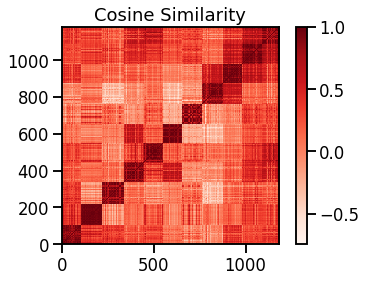

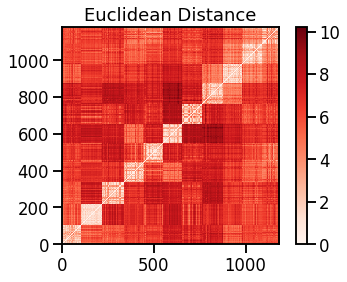

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '|']


In [51]:
character_examples = {}
num_samples = 100
for samp in range(num_samples):
    src, tgt, k, remember_text, forget_text = data_sample(vocabulary, Ks = range(2,11), verbose=True)
    model.eval()

    if transition_type == 'explicit' or transition_type == 'repeated':
        src_length = 2*k
    else:
        src_length = 2*k - 1

    true = tgt[1].item()

    src_mask = (src != len(vocabulary)).unsqueeze(-2)
    out = tr.greedy_decode(model, src, src_mask, max_len=2, start_symbol=len(vocabulary))

    encoder_output = model.encode(src, src_mask)[0]

    for char_idx, char in enumerate(remember_text):
        if char not in character_examples:
            character_examples[char] = []

        character_examples[char].append(encoder_output[char_idx, :].detach().numpy())

    if '|' not in character_examples:
        character_examples['|'] = []
    character_examples['|'].append(encoder_output[len(remember_text), :].detach().numpy())

    for char_idx, char in enumerate(forget_text):
        if char not in character_examples:
            character_examples[char] = []
        character_examples[char].append(encoder_output[char_idx + len(remember_text) + 1, :].detach().numpy())

character_encoding = None
text = []
for char in sorted(character_examples.keys()):
    text = text + [char]*len(character_examples[char])
    if character_encoding is None:
        character_encoding = np.array(character_examples[char])
    else:
        character_encoding = np.vstack((character_encoding, np.array(character_examples[char])))

similarity = np.zeros((len(character_encoding), len(character_encoding)))
distance = np.zeros((len(character_encoding), len(character_encoding)))
for i, A in enumerate(character_encoding):
    for j, B in enumerate(character_encoding):
        similarity[i,j] = cosine_similarity(A,B)
        distance[i,j] = np.linalg.norm(A-B)
plt.title('Cosine Similarity')      
plt.imshow(similarity,origin='lower', cmap='Reds')
# plt.xticks(text)
# plt.yticks(text)
plt.colorbar()
plt.show()
plt.close()

plt.title('Euclidean Distance')      
plt.imshow(distance,origin='lower', cmap='Reds')
# plt.xticks(text)
# plt.yticks(text)
plt.colorbar()
plt.show()
print(sorted(character_examples.keys()))



In [54]:
dims, std, npoints = idims.block_analysis(distance)
print('Average dimensionality',dims.mean())
print('With average std',std.mean())

Average dimensionality 3.0530294559488893
With average std 0.44034659732059317
